<a href="https://colab.research.google.com/github/drxxtc/adversarialAttack/blob/main/TransformerModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#Датасет

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
train_data = '/content/drive/MyDrive/data/PowerCons_TRAIN.txt'
test_data = '/content/drive/MyDrive/data/PowerCons_TEST.txt'

In [39]:
class Dataset2Class(torch.utils.data.Dataset):
    def __init__(self, path_dir:str):
        super().__init__()
        self.path_dir = path_dir
        self.data = np.genfromtxt(path_dir)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        t_data = torch.from_numpy(self.data[index][1:]).to(torch.float32)
        t_data = torch.reshape(t_data, (1, 144))
        t_label = torch.tensor(int(self.data[index][0]) - 1)
        return {'data': t_data, 'label': t_label}

In [40]:
train_dataset = Dataset2Class(train_data)
test_dataset = Dataset2Class(test_data)

#Transformer model

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [44]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, num_layers, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [49]:
def train_transformer(train_dataset, test_dataset, epochs=20, batch_size=64, learning_rate=0.001):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = TransformerClassifier(input_dim=144, d_model=64, n_heads=8, num_layers=2, num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    loss_data = {'train': [], 'test': []}
    accuracy_data = {'train': [], 'test': []}
    f1_data = {'train': [], 'test': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_labels = []
        train_preds = []

        for batch in train_loader:
            batch_X = batch['data']
            batch_y = batch['label']
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_labels.extend(batch_y.numpy())
            train_preds.extend(outputs.argmax(dim=1).numpy())


        train_loss /= len(train_loader)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        model.eval()
        test_loss = 0
        test_labels = []
        test_preds = []

        with torch.no_grad():
            for batch in test_loader:
                batch_X = batch['data']
                batch_y = batch['label']
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                test_labels.extend(batch_y.numpy())
                test_preds.extend(outputs.argmax(dim=1).numpy())

        test_loss /= len(test_loader)
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds, average='weighted')

        loss_data['train'].append(train_loss)
        loss_data['test'].append(test_loss)
        accuracy_data['train'].append(train_accuracy)
        accuracy_data['test'].append(test_accuracy)
        f1_data['train'].append(train_f1)
        f1_data['test'].append(test_f1)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}')
        print(f'Epoch {epoch+1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')

    return model, loss_data, accuracy_data, f1_data

In [50]:
model, loss_data, accuracy_data, f1_data  = train_transformer(train_dataset, test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20, Train Loss: 0.8746, Train Accuracy: 0.5278, Train F1: 0.5185
Epoch 1/20, Test Loss: 0.4777, Test Accuracy: 0.8222, Test F1: 0.8171
Epoch 2/20, Train Loss: 0.4652, Train Accuracy: 0.7222, Train F1: 0.6990
Epoch 2/20, Test Loss: 0.2971, Test Accuracy: 0.9556, Test F1: 0.9555
Epoch 3/20, Train Loss: 0.3003, Train Accuracy: 0.8889, Train F1: 0.8888
Epoch 3/20, Test Loss: 0.1295, Test Accuracy: 0.9556, Test F1: 0.9555
Epoch 4/20, Train Loss: 0.2288, Train Accuracy: 0.9333, Train F1: 0.9332
Epoch 4/20, Test Loss: 0.0499, Test Accuracy: 0.9889, Test F1: 0.9889
Epoch 5/20, Train Loss: 0.0388, Train Accuracy: 0.9889, Train F1: 0.9889
Epoch 5/20, Test Loss: 0.2052, Test Accuracy: 0.8889, Test F1: 0.8875
Epoch 6/20, Train Loss: 0.0869, Train Accuracy: 0.9556, Train F1: 0.9555
Epoch 6/20, Test Loss: 0.0150, Test Accuracy: 1.0000, Test F1: 1.0000
Epoch 7/20, Train Loss: 0.0288, Train Accuracy: 0.9944, Train F1: 0.9944
Epoch 7/20, Test Loss: 0.0369, Test Accuracy: 0.9889, Test F1: 0.9889

In [53]:
def draw(loss_data, accuracy_data, f1_data):

    plt.figure(figsize=(15, 10))

    # Plot CrossEntropy Loss
    plt.subplot(2, 2, 1)
    plt.plot(loss_data['train'], label='Train CrossEntropy Loss')
    plt.plot(loss_data['test'], label='Validation CrossEntropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CrossEntropy Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_data['train'], label='Train Accuracy')
    plt.plot(accuracy_data['test'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot F1-score
    plt.subplot(2, 2, 3)
    plt.plot(f1_data['train'], label='Train F1-score')
    plt.plot(f1_data['test'], label='Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score')
    plt.legend()

    plt.show()

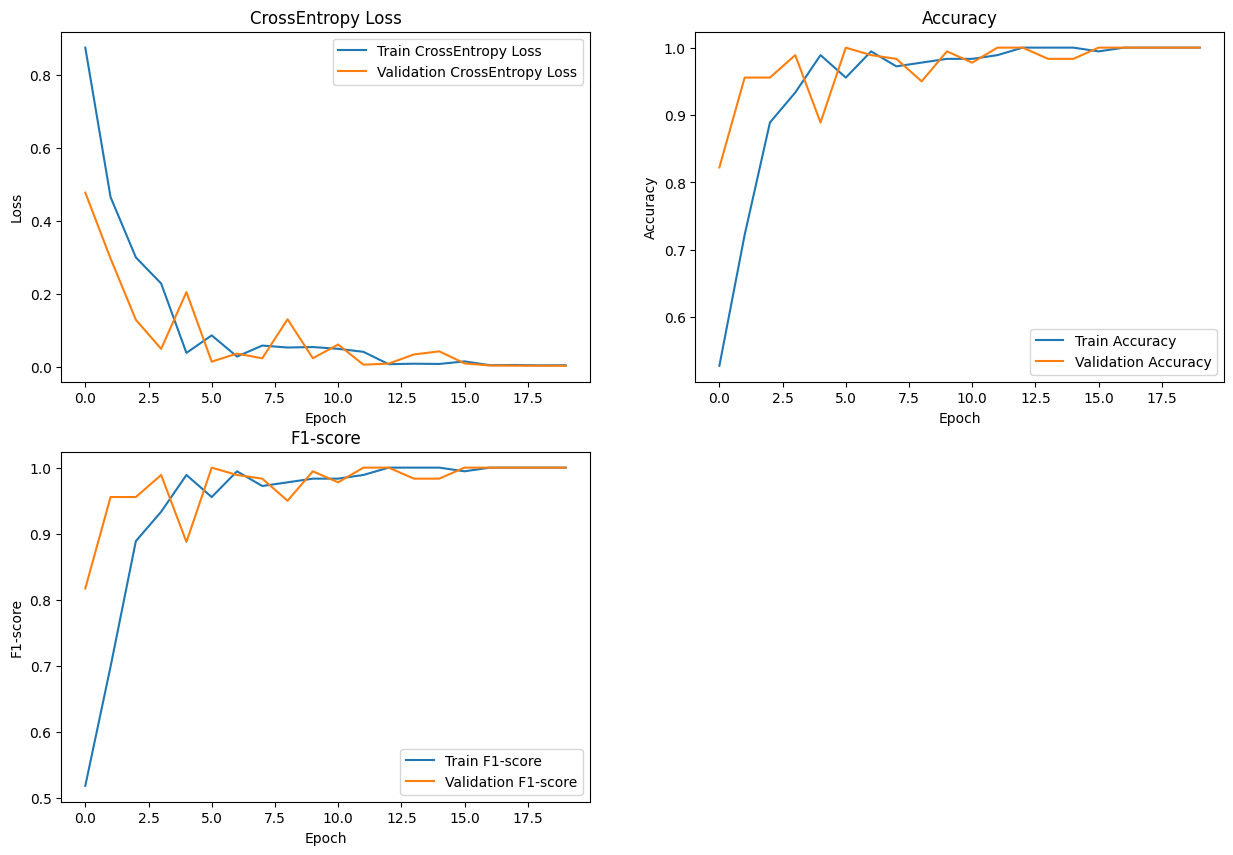

In [54]:
draw(loss_data, accuracy_data, f1_data)